# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium
from tyssue import BulkGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.utils.utils import _to_3d 
from tyssue.core.generation import three_faces_sheet
from tyssue.core.generation import extrude
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw

from tyssue.topology.bulk_topology import IH_transition, HI_transition

    
class RNRGeometry(BulkGeometry):
    
    @staticmethod
    def update_centroid(eptm):

        srce_pos = eptm.upcast_srce(eptm.vert_df[eptm.coords])
        trgt_pos = eptm.upcast_trgt(eptm.vert_df[eptm.coords])
        mid_pos = (srce_pos + trgt_pos)/2
        
        eptm.face_df[eptm.coords] = (eptm.sum_face(mid_pos * _to_3d(eptm.edge_df['length'])).values /
                                     eptm.face_df['perimeter'].values[:, np.newaxis])
        srce_pos['cell'] = eptm.edge_df['cell']
        eptm.cell_df[eptm.coords] = srce_pos.groupby('cell').mean()

sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets,
                   method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)
#BulkGeometry.update_all(eptm)
#BulkGeometry.center(eptm)


eptm.settings['threshold_length'] = 1e-4
print(eptm.Nf, eptm.Ne, eptm.Nv)

93 414 70


In [2]:
from tyssue import SheetGeometry
SheetGeometry.update_all(sheet)
np.alltrue(sheet.edge_df['nz'] > 0)

True

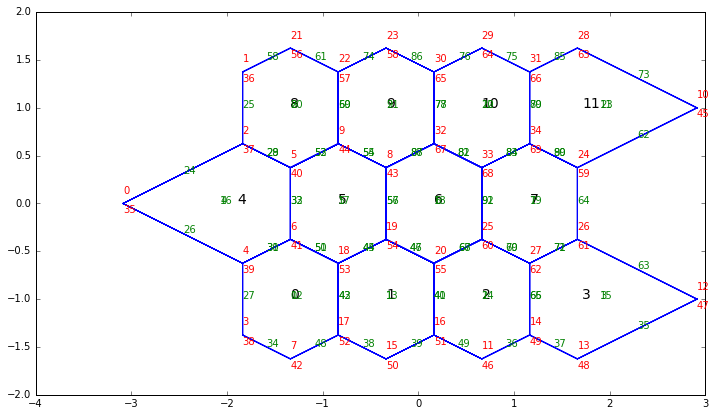

In [3]:
fig, ax = plt.subplots()
quick_edge_draw(eptm, ax=ax)
for c, data in eptm.cell_df.iterrows():
    ax.text(data.x, data.y, str(c), fontsize=14)
for v, data in eptm.vert_df[eptm.vert_df['segment']=='apical'].iterrows():
    ax.text(data.x, data.y+0.1, str(v), color='r')
for v, data in eptm.vert_df[eptm.vert_df['segment']=='basal'].iterrows():
    ax.text(data.x, data.y-0.1, str(v), color='r')

for f, data in eptm.face_df.iterrows():
    ax.text(data.x, data.y, str(f), color='g')
    
fig.set_size_inches(12, 12)

In [4]:
render, line = view_3js(eptm)
display(render)

## I→H transition

![IH transition in a bulk and a monolayer](../data/png/IH_transition.png)



In [5]:
e_1011 = 26
eptm.settings['threshold_length'] = 1

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)


In [6]:
render, line = view_3js(eptm)
display(render)

# H → I transition

In [7]:
fa = 93

HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

In [8]:
render, line = view_3js(eptm)
display(render)